In [16]:
'''
Multi-class image classification for an Emotion Recognition task.
'''

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
###            ###
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os
import cv2

## PARAMETERS ##
print_tensorflow_GPU_info = False
tensorflow_verbosity = "INFO"  # DEBUG(10): All | INFO(20): Info&Warning | WARN(30)[Default]: Warning | ERROR(40): Error | FATAL(50): None
random_state = 22
    # General
dataset_name = "JAFFE"
multiclass = True
num_features = 64
num_labels = 7
width, height = 48, 48
channels = 1
load_npy = True
data_generator = False
    # Convolution
kernel_size = (3, 3)
pool_size = (2, 2)
strides = (2, 2)
dropout = 0.3
    # Training
batch_size = 64
epochs = 10
loss = "categorical_crossentropy"
optimizer = "adam"
eval_metrics = "accuracy"
##             ##

## Reproducibility ## 
random.seed(random_state)  # Python's seed
np.random.seed(random_state)  # Numpy's seed
tf.set_random_seed(random_state)  # Tensorflow's seed
##                 ##

In [2]:
## GPU usage settings for Tensorflow backend ##
# RTX GPU Memory BUG Fix & Must also be placed at the top of the code else it doesn't work
from keras.backend import tensorflow_backend as K
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True                     # dynamically grow the memory used on the GPU
#tf_config.gpu_options.per_process_gpu_memory_fraction = 0.9  # fraction of the GPU to be used
#tf_config.log_device_placement = True                        # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=tf_config)
K.set_session(sess)                     # set this TensorFlow session as the default session for Keras
##                                                                                          ##     

## Tensorflow Verbosity Module ##
default_verbosity = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(tensorflow_verbosity)
print(f"\n--CHANGED TENSORFLOW VERBOSITY FROM {default_verbosity/10:.0f} (default) TO {tf.compat.v1.logging.get_verbosity()/10:.0f}")
##                             ##

## Tensorflow GPU Information Module ##
if print_tensorflow_GPU_info == True:
    print(f"\n--AVAILABLE GPUS:")
    K._get_available_gpus()
    print(f"\n--NUM OF GPUs AVAILABLE: {len(tf.config.experimental.list_physical_devices('GPU'))}")
    print(f"\n--IS TF BUILT WITH CUDA: {tf.test.is_built_with_cuda()}")
    print(f"\n--IS GPU AVAILABLE: {tf.test.is_gpu_available()}")
##                                   ##  


--CHANGED TENSORFLOW VERBOSITY FROM 2 (default) TO 2


## Dataset Loading

In [19]:
''' Dataset Loading '''
if dataset_name == "FER-2013":
    # CSV Mode, also features class and test/train distribution visualizations
    if load_npy == False:
        data = pd.read_csv("./Datasets/FER-2013/fer2013.csv")
        data.rename(columns={"emotion": "label"}, inplace=True)
        display(data.head())

        # Preprocessing 
        print("\nEach instance consists of:", len(data.iloc[0, [1]].values[0].split()), "pixels")
        datapoints = data['pixels'].tolist()

        # Convert a sequence of pixels to YxY
        X = []
        for xseq in datapoints:
            xx = [int(xp) for xp in xseq.split(' ')]
            xx = np.asarray(xx).reshape(width, height)
            X.append(xx.astype('float32'))

        X = np.asarray(X)
        X = np.expand_dims(X, -1)

        # Get Labels
        y = to_categorical(data['label'])

        # Get train/tase usage mask
        train_test_usage = data['Usage'].values
        tmask = np.isin(train_test_usage, 'Training')

        print("Loading and Preprocessing Done")
        print("Number of Features: " + str(X[0].shape))
        print("Number of Class Labels: " + str(len(y[0])))
        print("Number of instances in dataset: " + str(len(X)))

        # Store data as .npy
        np.save('./Datasets/FER-2013/fdata', X)
        np.save('./Datasets/FER-2013/flabels', y)
        np.save('./Datasets/FER-2013/ftraintestmask', tmask)
        print("Data and labels got stored to .npy files")

    # NPY Mode   
    elif load_npy == True:
        X = np.load('./Datasets/FER-2013/fdata.npy')
        y = np.load('./Datasets/FER-2013/flabels.npy')
        tmask = np.load('./Datasets/FER-2013/ftraintestmask.npy')
        print("Data loaded from .npy files")

elif dataset_name == "JAFFE":
    # Load images
    data_path = "./Datasets/Japanese Female Facial Expression (JAFFE) Dataset/PNG Format"    
    data_dir_list = os.listdir(data_path)

    img_data_list=[]

    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{} with length {}'.format(dataset, len(img_list)))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img, cv2.IMREAD_GRAYSCALE)
            input_img_resize=cv2.resize(input_img, (128,128))
            img_data_list.append(input_img_resize)
            
    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    img_data = img_data/255
    img_data = np.expand_dims(img_data, axis=3)
    print(img_data.shape, "\n")

    # Define the number of classes
    num_of_samples = img_data.shape[0]
    labels = np.ones((num_of_samples,),dtype='int64')
    labels[0:30]=0 #30
    labels[30:59]=1 #29
    labels[59:91]=2 #32
    labels[91:122]=3 #31
    labels[122:152]=4 #30
    labels[152:183]=5 #31
    labels[183:]=6 #30  
    names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

    # Convert class labels to on-hot encoding 
    Y = to_categorical(labels, num_labels)

    # Shuffle the dataset
    x, y = shuffle(img_data, Y, random_state=random_state)
    print("Loading Done")

## EXAMPLE LOADING: Folder filled with images into a Generator ##
elif dataset_name == "Dogs vs. Cats":
    filenames = os.listdir("./Datasets/Dogs vs. Cats/train")
    categories = []
    for filename in filenames:
        category = filename.split('.')[0]
        if category == 'dog':
            categories.append(1)
        else:
            categories.append(0)

    df = pd.DataFrame({
        'Filename': filenames,
        'Label': categories
    })

    # Convert column category into string, since it will get converted into one-hot in the future
    df["Label"] = df["Label"].replace({0: 'cat', 1: 'dog'}) 

    print("Loading Done")
    print("Dataset Info:\n", df.head(3), "\n\n", df.loc[:,'Label'].value_counts(), "\n\n", sep="")
##                                            ##   

else:
    raise ValueError("Dataset is not implemented yet")

print("Dataset Loading done")

Loaded the images of dataset-ANGRY with length 30
Loaded the images of dataset-DISGUST with length 29
Loaded the images of dataset-FEAR with length 32
Loaded the images of dataset-HAPPY with length 31
Loaded the images of dataset-NEUTRAL with length 30
Loaded the images of dataset-SAD with length 31
Loaded the images of dataset-SURPRISE with length 30
(213, 128, 128, 1) 

Loading Done
Dataset Loading done


## Dataset Visualizations

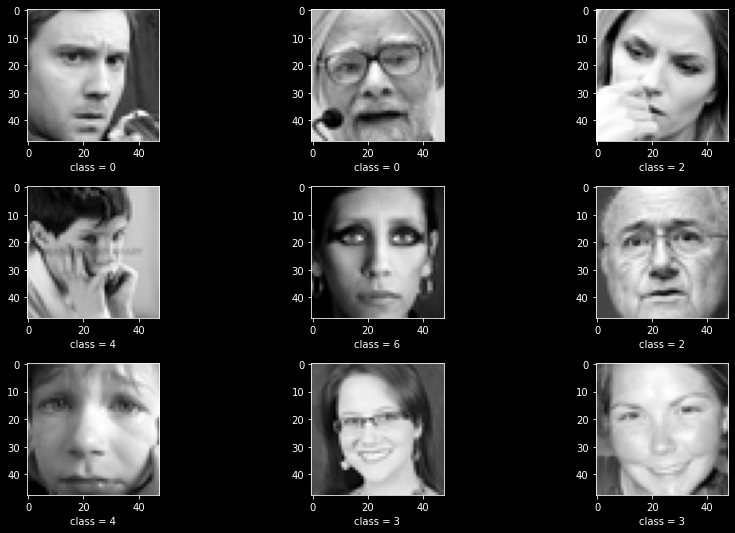

In [4]:
''' Visualize samples and distributions regarding the dataset '''
if dataset_name == "FER-2013":
        # Class and test/train distribution visualizations (CSV Mode)
        if load_npy == False:
            fig = plt.figure(figsize=[12, 8])
            ax1 = fig.add_subplot(221)
            data['label'].value_counts().plot.bar()
            ax2 = fig.add_subplot(222)
            data['Usage'].value_counts().plot.bar() 

        # Additional Random Samples visualization
        plt.figure(figsize=(12, 12))
        for i, pixels in enumerate(X[0:9]):
            plt.subplot(5, 3, i+1)
            plt.imshow(pixels[:,:,0], cmap='gray')  # (256L, 256L, 1L) cannot be plotted therefore we need to get rid of the last dimension -> (256L, 256L)
            plt.xlabel("class = " + "{}".format(np.argmax(y[i], axis=-1))) 
        plt.tight_layout()
        plt.show()

## EXAMPLE VISUALIZE: Folder filled with images into a Generator ##
if dataset_name == "Dogs vs. Cats":
    sample = random.choice(filenames)
    image = load_img("./Datasets/Dogs vs. Cats/train/"+sample)
    plt.imshow(image)
##                                            ## 

## Dataset Preprocessing

In [5]:
print("Dataset Preprocessing done, no feature extraction")

Dataset Preprocessing done, no feature extraction


## Train/test splitting

In [6]:
''' Dataset train/test splitting '''
if dataset_name == "FER-2013":
    X_train, y_train = X[tmask], y[tmask]
    X_test, y_test = X[~tmask], y[~tmask]
elif dataset_name == "JAFFE":    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=random_state)

# Print Dataset Informatiom  
print(dataset_name, "Loaded. Training entries:", len(X_train), "\b, labels:", len(y_train))      
print(type(X_train[0]))
print(X_train[0])
print(y_train[0])
print("Train/test splitting done") 

FER-2013 Loaded. Training entries: 28709, labels: 28709
<class 'numpy.ndarray'>
[[[ 70.]
  [ 80.]
  [ 82.]
  ...
  [ 52.]
  [ 43.]
  [ 41.]]

 [[ 65.]
  [ 61.]
  [ 58.]
  ...
  [ 56.]
  [ 52.]
  [ 44.]]

 [[ 50.]
  [ 43.]
  [ 54.]
  ...
  [ 49.]
  [ 56.]
  [ 47.]]

 ...

 [[ 91.]
  [ 65.]
  [ 42.]
  ...
  [ 72.]
  [ 56.]
  [ 43.]]

 [[ 77.]
  [ 82.]
  [ 79.]
  ...
  [105.]
  [ 70.]
  [ 46.]]

 [[ 77.]
  [ 72.]
  [ 84.]
  ...
  [106.]
  [109.]
  [ 82.]]]
[1. 0. 0. 0. 0. 0. 0.]
Train/test splitting done


## Data Generators

In [7]:
''' Data Generators '''
if data_generator == True:
    train_datagen = ImageDataGenerator(
        rotation_range=10,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    train_datagen.fit(X_train)
    train_generator = train_datagen.flow(  # Generates batches of augmented data
        X_train,
        y_train,
        batch_size=batch_size
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow(  # Generates batches of augmented data
        X_test,
        y_test,
        batch_size=batch_size    
    )

## Model Building

In [8]:
''' Model Building '''
model = Sequential()

model.add(Conv2D(num_features, kernel_size=kernel_size, activation='relu', input_shape=(width, height, channels), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Dropout(dropout))

model.add(Conv2D(2*num_features, kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Dropout(dropout))

model.add(Conv2D(2*2*num_features, kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Dropout(dropout))

model.add(Conv2D(2*2*2*num_features, kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Dropout(dropout))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(dropout-0.1))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(dropout-0.1))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=[eval_metrics])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
______________________________________

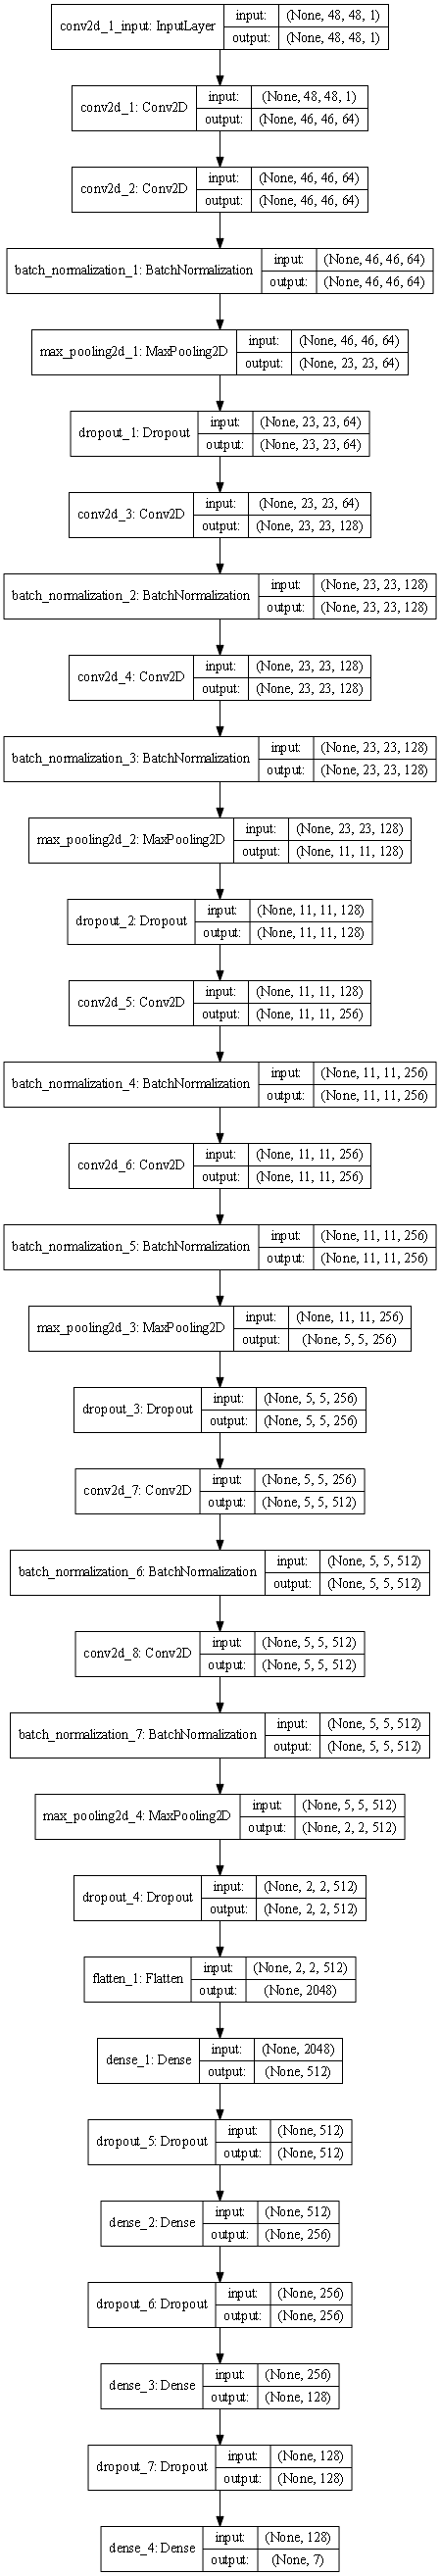

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=72)

In [10]:
''' Callbacks '''
early_stop = EarlyStopping(monitor='val_loss', mode='min', baseline=None, patience=3, verbose=1)
model_save = ModelCheckpoint('Saved Models/Basic_image_FER_etc.h5', monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1)


## Model Training

In [11]:
#X_train =  X_train[0:20]
#y_train = y_train[0:20]

In [12]:
''' Model Training with Generators '''
if data_generator == True:
    history = model.fit_generator(train_generator, 
                                  steps_per_epoch=len(X_train)//batch_size, 
                                  epochs=epochs,       
                                  validation_data=validation_generator,
                                  validation_steps=len(X_test)//batch_size,
                                  callbacks=[early_stop, model_save, reduce_lr],
                                  verbose=1)

In [13]:
''' Model Training '''
if data_generator == False:
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        #validation_split=0.1,
                        callbacks=[early_stop, model_save, reduce_lr],
                        verbose=1)


Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 23s 798us/step - loss: 1.8620 - accuracy: 0.2525 - val_loss: 1.7184 - val_accuracy: 0.2990
Epoch 2/10
28709/28709 [==============================] - 20s 684us/step - loss: 1.6057 - accuracy: 0.3662 - val_loss: 1.7514 - val_accuracy: 0.2857
Epoch 3/10
28709/28709 [==============================] - 17s 603us/step - loss: 1.4381 - accuracy: 0.4482 - val_loss: 1.4140 - val_accuracy: 0.4521
Epoch 4/10
11712/28709 [===========>..................] - ETA: 10s - loss: 1.3460 - accuracy: 0.4896

KeyboardInterrupt: 

## Evaluate Model

In [14]:
''' Evaluate Model '''
results = model.evaluate(X_test, y_test)
print()

for i in range(len(model.metrics_names)):
    print("Metric - {}: {:.5f}".format(model.metrics_names[i], results[i]*100))

if multiclass == False: 
    predictions = [1 * (x[0]>=0.5) for x in model.predict(X_test)]
    cm = confusion_matrix(y_test, predictions)
else:    
    predictions = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test.argmax(axis=1), predictions)
print()
print(cm)

7178/7178 [==============================] - 2s 301us/step

Metric - loss: 141.09982
Metric - accuracy: 45.69518

[[ 173    0   25  146  527   18   69]
 [  25    0    2   15   60    1    8]
 [  65    0   51  189  507   87  125]
 [  12    0   11 1455  250   17   29]
 [  50    0   16  178  842    9  152]
 [  17    0   94  112  119  423   66]
 [  35    0   10  170  672   10  336]]


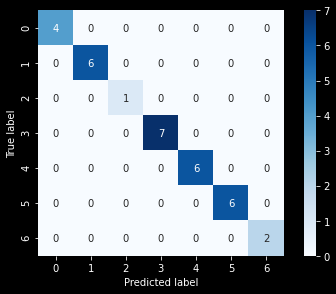

In [24]:
heatmap(cm, fmt="g", annot=True, square=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Model Analysis

### Model Analysis: **Overfitting**

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


<Figure size 432x288 with 0 Axes>

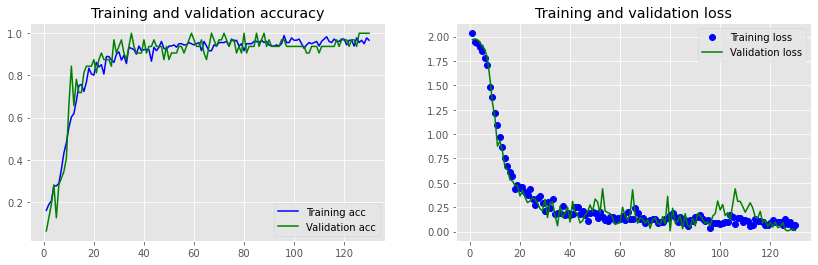

In [25]:
def plot_model_history():
    plt.clf()  # clear figure
    
    plt.style.use('ggplot')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 4))
    plt.rcParams['text.color'] = 'k'
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

print(history.history.keys())    
plot_model_history()
plt.style.use('dark_background')

## Result Visualizations

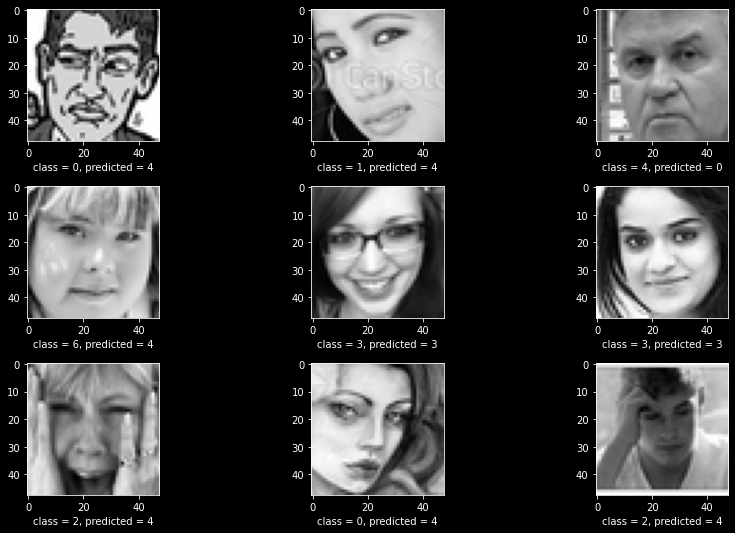

In [15]:
''' Visualize samples alongside predictions on the dataset '''
if dataset_name == "FER-2013":
    predictions_df = pd.DataFrame({'id': np.where(~tmask)[0]})
    predictions_df['class'] = predictions

    plt.figure(figsize=(12, 12))
    for i, pixels in enumerate(X[~tmask][0:9]):
        plt.subplot(5, 3, i+1)
        plt.imshow(pixels[:,:,0], cmap='gray')  # (256L, 256L, 1L) cannot be plotted therefore we need to get rid of the last dimension -> (256L, 256L)
        plt.xlabel("class = " + "{}".format(np.argmax(y[~tmask][i], axis=-1)) + ", predicted = " + "{}".format(predictions_df.loc[i, "class"])) 
    plt.tight_layout()
    plt.show()

# Load Model

In [37]:
''' Load Model '''
model = load_model('Saved Models/Basic_image_FER_etc.h5')
#model = load_model('best_model_text.h5', custom_objects={'MultiplicativeLSTM': MultiplicativeLSTM})  # Handling saved models changes if we are using custom (3rd-party) layers

# Evaluate on External Data

In [38]:
''' Evaluation Phase '''
###   INPUT    ###
test_image = X[~tmask][0]  # An instance of FER dataset
test_image = np.expand_dims(test_image, axis=0)  # Expand dimensions to include a single batch
###            ###

def evaluate_single_sentence(dataset_name, model, test_image, multiclass):
    if dataset_name == "FER-2013":   
        if multiclass == False: 
            probability = model.predict(test_image)
            predictions = [1 * (x[0]>=0.5) for x in probability]    
        else:    
            probability = model.predict(test_image)
            predictions = np.argmax(probability, axis=1)
            probability = np.array([[probability[0][predictions[0]]]])  # Convert to the same format as multiclass == False

        # 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
        if predictions[0] == 0:
            return ("Angry", probability) 
        elif predictions[0] == 1:
            return ("Disgust", probability)
        elif predictions[0] == 2:
            return ("Fear", probability)
        elif predictions[0] == 3:
            return ("Happy", probability)
        elif predictions[0] == 4:
            return ("Sad", probability)
        elif predictions[0] == 5:
            return ("Surprise", probability)
        elif predictions[0] == 6:
            return ("Neutral", probability)        
        else:
            return ("no prediction", None)

print(evaluate_single_sentence(dataset_name, model, test_image, multiclass))

('Neutral', array([[0.35899428]], dtype=float32))
